In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
# -------------------------------------------------------
# Load CSVs
# -------------------------------------------------------
baseline_path = "bld_baseline_eval.csv"
improved_path = "bld_adaptive_mask_v3_eval.csv"

df_base = pd.read_csv(baseline_path)
df_impr = pd.read_csv(improved_path)

print(df_base.columns)
print(df_impr.columns)

Index(['file_id', '2_blended-latent-diffusion|structure_distance',
       '2_blended-latent-diffusion|psnr_unedit_part',
       '2_blended-latent-diffusion|lpips_unedit_part',
       '2_blended-latent-diffusion|mse_unedit_part',
       '2_blended-latent-diffusion|ssim_unedit_part',
       '2_blended-latent-diffusion|clip_similarity_source_image',
       '2_blended-latent-diffusion|clip_similarity_target_image',
       '2_blended-latent-diffusion|clip_similarity_target_image_edit_part'],
      dtype='object')
Index(['file_id', '2_bld_adaptive_mask|structure_distance',
       '2_bld_adaptive_mask|psnr_unedit_part',
       '2_bld_adaptive_mask|lpips_unedit_part',
       '2_bld_adaptive_mask|mse_unedit_part',
       '2_bld_adaptive_mask|ssim_unedit_part',
       '2_bld_adaptive_mask|clip_similarity_source_image',
       '2_bld_adaptive_mask|clip_similarity_target_image',
       '2_bld_adaptive_mask|clip_similarity_target_image_edit_part'],
      dtype='object')


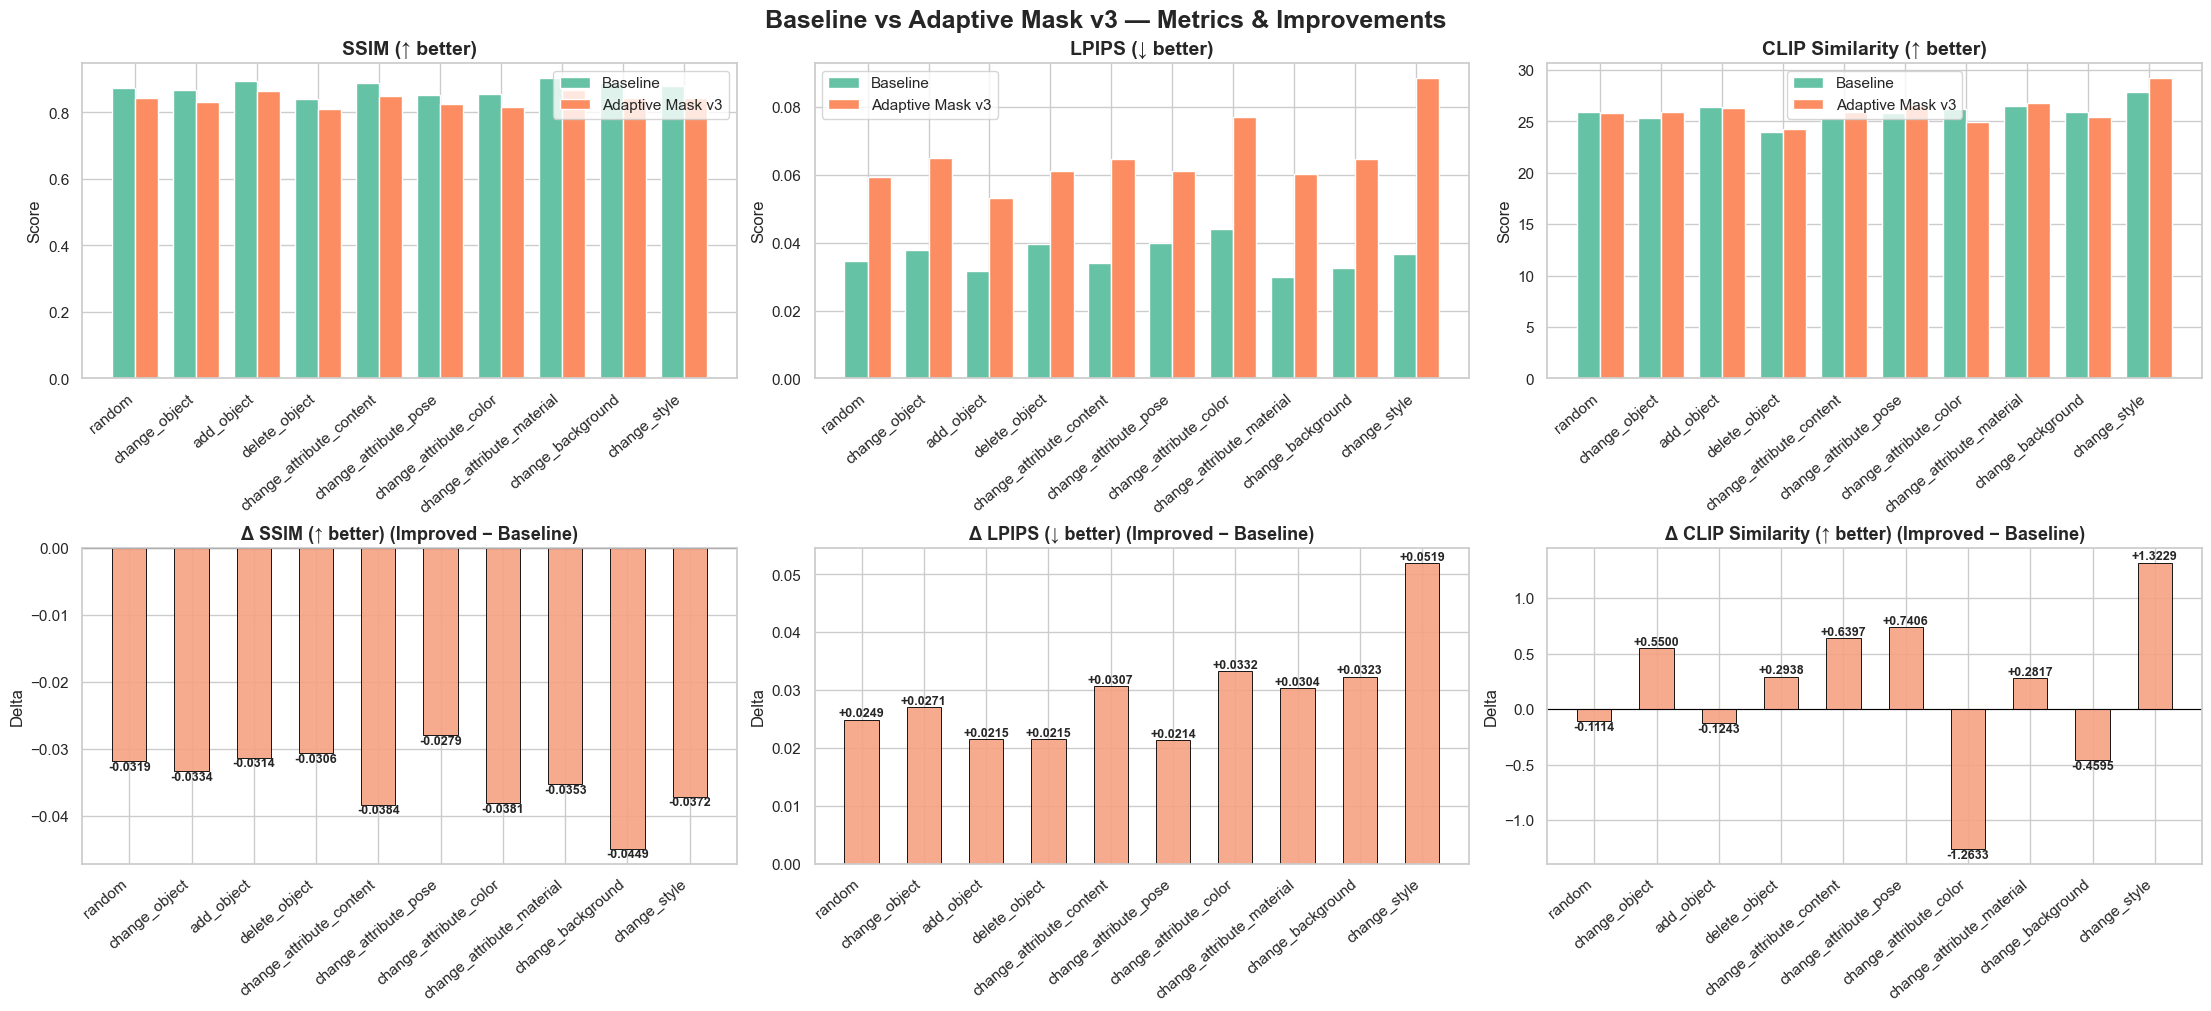


================= METRIC SUMMARY =================

----- SSIM (↑ better) -----
Baseline:  mean = 0.8723,  std = 0.1018
Improved:  mean = 0.8379,  std = 0.1082
Δ (Improved − Baseline): -0.0344

----- LPIPS (↓ better) -----
Baseline:  mean = 0.0359,  std = 0.0187
Improved:  mean = 0.0624,  std = 0.0285
Δ (Improved − Baseline): +0.0266

----- CLIP Similarity (↑ better) -----
Baseline:  mean = 25.9151,  std = 3.8186
Improved:  mean = 26.0965,  std = 3.8559
Δ (Improved − Baseline): +0.1814



In [4]:
# -------------------------------------------------------
# Editing-type labels (row-ranges)
# -------------------------------------------------------
editing_types = [
    "random",
    "change_object",
    "add_object",
    "delete_object",
    "change_attribute_content",
    "change_attribute_pose",
    "change_attribute_color",
    "change_attribute_material",
    "change_background",
    "change_style",
]

category_sizes = [140, 80, 80, 80, 40, 40, 40, 40, 80, 80]
df_base["editing_type"] = np.repeat(editing_types, category_sizes)
df_impr["editing_type"] = np.repeat(editing_types, category_sizes)

# -------------------------------------------------------
# Column names (exact)
# -------------------------------------------------------
base_cols = {
    "SSIM (↑ better)": "2_blended-latent-diffusion|ssim_unedit_part",
    "LPIPS (↓ better)": "2_blended-latent-diffusion|lpips_unedit_part",
    "CLIP Similarity (↑ better)": "2_blended-latent-diffusion|clip_similarity_target_image",
}

impr_cols = {
    "SSIM (↑ better)": "2_bld_adaptive_mask|ssim_unedit_part",
    "LPIPS (↓ better)": "2_bld_adaptive_mask|lpips_unedit_part",
    "CLIP Similarity (↑ better)": "2_bld_adaptive_mask|clip_similarity_target_image",
}

# -------------------------------------------------------
# Compute means
# -------------------------------------------------------
base_mean = (
    df_base.groupby("editing_type")
    .mean(numeric_only=True)
    .loc[editing_types]
)
impr_mean = (
    df_impr.groupby("editing_type")
    .mean(numeric_only=True)
    .loc[editing_types]
)

# -------------------------------------------------------
# Δ = improved − baseline (build explicitly per metric)
# -------------------------------------------------------
delta_dict = {}
for metric_name in base_cols.keys():
    base_col = base_cols[metric_name]
    impr_col = impr_cols[metric_name]
    delta_dict[metric_name] = (
        impr_mean[impr_col] - base_mean[base_col]
    )

delta = pd.DataFrame(delta_dict).loc[editing_types]  # index already matches

# -------------------------------------------------------
# Plot styling
# -------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

colors_base_impr = sns.color_palette("Set2", 2)
color_delta = sns.color_palette("coolwarm", 10)[7]  # nice warm-ish color

# -------------------------------------------------------
# Main figure: 2 rows × 3 columns
# -------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(22, 10), constrained_layout=True)
x = np.arange(len(editing_types))
bar_width = 0.38

# -------------------------------------------------------
# Row 1: Baseline vs Improved
# -------------------------------------------------------
for ax, metric_name in zip(axes[0], base_cols.keys()):
    base_col = base_cols[metric_name]
    impr_col = impr_cols[metric_name]

    ax.bar(
        x - bar_width/2,
        base_mean[base_col],
        width=bar_width,
        color=colors_base_impr[0],
        label="Baseline",
    )

    ax.bar(
        x + bar_width/2,
        impr_mean[impr_col],
        width=bar_width,
        color=colors_base_impr[1],
        label="Adaptive Mask v3",
    )

    ax.set_title(metric_name, fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(editing_types, rotation=40, ha="right")
    ax.set_ylabel("Score")
    ax.legend()

# -------------------------------------------------------
# Row 2: Delta plots (Improved − Baseline)
# -------------------------------------------------------
for ax, metric_name in zip(axes[1], delta.columns):
    vals = delta[metric_name]

    bars = ax.bar(
        x,
        vals,
        width=0.55,
        color=color_delta,
        alpha=0.9,
        edgecolor="black",
        linewidth=0.7,
    )

    # Annotate each bar with the delta value
    for bar, val in zip(bars, vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{val:+.4f}",       # formatted "+0.0123"
            ha="center",
            va="bottom" if val >= 0 else "top",
            fontsize=9,
            fontweight="bold",
        )

    ax.set_title(f"Δ {metric_name} (Improved − Baseline)", fontsize=13, fontweight="bold")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(editing_types, rotation=40, ha="right")
    ax.set_ylabel("Delta")

# -------------------------------------------------------
# Save + show
# -------------------------------------------------------
fig.suptitle("Baseline vs Adaptive Mask v3 — Metrics & Improvements", fontsize=18, fontweight="bold")
# fig.savefig("baseline_vs_adaptivemask_v3_with_deltas.pdf", bbox_inches="tight")
plt.show()

# -------------------------------------------------------
# Compute overall mean & std for key metrics
# -------------------------------------------------------

print("\n================= METRIC SUMMARY =================\n")

for metric_name in base_cols.keys():
    base_col = base_cols[metric_name]
    impr_col = impr_cols[metric_name]

    base_vals = df_base[base_col].astype(float)
    impr_vals = df_impr[impr_col].astype(float)

    print(f"----- {metric_name} -----")
    print(f"Baseline:  mean = {base_vals.mean():.4f},  std = {base_vals.std():.4f}")
    print(f"Improved:  mean = {impr_vals.mean():.4f},  std = {impr_vals.std():.4f}")
    print(f"Δ (Improved − Baseline): {impr_vals.mean() - base_vals.mean():+.4f}\n")